In [25]:
using Revise

In [26]:
using LazySets
using ModelVerification

In [27]:
using PyCall
using CSV
using ONNX
using Flux
using DataFrames
using ONNXNaiveNASflux 

In [28]:
include("vnnlib_parser.jl")

read_vnnlib_simple (generic function with 1 method)

In [29]:

function onnx_to_nnet(onnx_file)
    pushfirst!(PyVector(pyimport("sys")."path"), dirname(dirname(@__FILE__)))
    nnet = pyimport("NNet")
    use_gz = split(onnx_file, ".")[end] == "gz"
    if use_gz
        onnx_file = onnx_file[1:end-3]
    end
    nnet_file = onnx_file[1:end-4] * "nnet"
    isfile(nnet_file) && return
    nnet.onnx2nnet(onnx_file, nnetFile=nnet_file)
end

function verify_an_instance(onnx_file, spec_file, timeout)
    use_gz = split(onnx_file, ".")[end] == "gz"
    nnet_file = use_gz ? onnx_file[1:end-7] * "nnet" : onnx_file[1:end-4] * "nnet"
    net = ModelVerification.read_nnet(nnet_file)
    ###### TODO: change this ad-hoc remedy for nnet read ######
    net.layers[1] = ModelVerification.Layer(net.layers[1].weights, net.layers[1].bias, ModelVerification.Id())
    flux_model = Flux.Chain(net)
    println(flux_model)
    new_onnx_file = "/home/verification/ModelVerification.jl/tmp/" * onnx_file[end-31:end]
    #ONNXNaiveNASflux.save(new_onnx_file, flux_model, (5,5))
    n_in = size(net.layers[1].weights)[2]
    n_out = length(net.layers[end].bias)
    specs = read_vnnlib_simple(spec_file, n_in, n_out)
    #current_time = 0
    for spec in specs
        X_range, Y_cons = spec
        lb = [bd[1] for bd in X_range]
        ub = [bd[2] for bd in X_range]
        X = Hyperrectangle(low = lb, high = ub)
        res = nothing
        A = []
        b = []
        # println("fuck")
        # println(Y_cons)
        for Y_con in Y_cons
            A = hcat(Y_con[1]...)'
            b = Y_con[2]
            Yc = HPolytope(A, b)
            Y = Complement(Yc)
            search_method = BFS(max_iter=3e5, batch_size=512)
            split_method = BaBSR(2)#Bisect(1)
            prop_method = BetaCrown(true, 2, Crown(true, true, true), true, false, Flux.Optimiser(Flux.ADAM(0.1)), 10)
            problem = Problem(new_onnx_file, X, Y)
            res = @timed verify(search_method, split_method, prop_method, problem)
            #current_time += res.time 
            #println(current_time)
            #if(current_time >= timeout)
                #println("timed out at:", current_time)
                #return "unknown"
            #end
            res.value.status == :violated && (return "violated")
            res.value.status == :unknown && (return "unknown")
        end
    end
    return "holds"
end

function run_all(instance_csv, result_csv)
    file = CSV.File(instance_csv, header=false)
    dirpath = dirname(instance_csv)
    df = DataFrame()
    for (index,row) in enumerate(file)
        println("Instance $index.")
        onnx_file = joinpath(dirpath, row[1])
        vnnlib_file = joinpath(dirpath, row[2])
        timeout = row[3]
        onnx_to_nnet(onnx_file)
        result = @timed verify_an_instance(onnx_file, vnnlib_file, timeout)
        println(result)
        push!(df, result)
    end
    CSV.write(result_csv, df)
end

run_all (generic function with 1 method)

In [30]:
# # expected holds
onnx_file = "../../vnncomp2021/benchmarks/acasxu/ACASXU_run2a_4_5_batch_2000.onnx"
spec_file = "../../vnncomp2021/benchmarks/acasxu/prop_10.vnnlib"
# expected violated
#onnx_file = "/home/verification/vnncomp2021/benchmarks/acasxu/ACASXU_run2a_1_2_batch_2000.onnx"
#spec_file = "/home/verification/vnncomp2021/benchmarks/acasxu/prop_2.vnnlib"
timeout = 116
verify_an_instance(onnx_file, spec_file, timeout)

Chain(Dense(5 => 5), Dense(5 => 50, relu), Dense(50 => 50, relu), Dense(50 => 50, relu), Dense(50 => 50, relu), Dense(50 => 50, relu), Dense(50 => 50, relu), Dense(50 => 5))


start
1
Any[(Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([0.474418098, 0.305704178, -0.4992041215, 0.3636363635, 0.25], [0.20543967099999993, 0.194295718, 0.0007957745000000127, 0.1363636365, 0.25]), Dict{Any, Any}())]
1125.857014199773
1105.7458304614347
1098.6645588368576
1090.8386117798277
1083.2093913330132
1078.2959032363915
1073.8453883054826
1070.454531170354
1068.1739785143118
1066.077692284829


spec_l, spec_u
[-1064.354388491566;;]
[-1061.837901842604;;]
2
3
Any[(Hyperrectangle{Float64, Vector{Float64}, Vector{Float64}}([0.474418098, 0.305704178, -0.4992041215, 0.3636363635, 0.25], [0.20543967099999993, 0.194295718, 0.0007957745000000127, 0.1363636365, 0.25]), Dict{String, Vector{Any}}("relu_1" => [nothing, nothing, nothing, nothing], "relu_4" => [nothing, nothing, nothing, nothing], "relu_6" => [[4, 9], [0.0; 0.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0.0;;], [1.0; 1.0; 1.0; -1.0; 1.0; 1.0; 1.0; 1.0; -1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0; 1.0;;], [0.0; 0.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 1.0; 0.0; 0.0; 0.0; 0.0; 0.0; 0

2223.986584985007
2301.2276250359396
2315.001100720527
spec_l, spec_u
[-1133.5809000970264 -1133.5809000970264]
[-1129.641996500598 -1129.641996500598]


"unknown"

In [ ]:
run_all("/home/verification/vnncomp2021/benchmarks/acasxu/acasxu_instances.csv", "./alphacrown_result.csv")

In [37]:
time1 = @elapsed begin
    # 执行一些耗时的操作
    sleep(2)  # 模拟一个耗时的操作，程序将休眠2秒
end
time2 = @elapsed begin
    # 执行一些耗时的操作
    sleep(5)  # 模拟一个耗时的操作，程序将休眠2秒
end
println("代码已经运行了 $elapsed_time 秒")
println(time2+time1)

代码已经运行了 8.001899456 秒
7.002479682000001


In [57]:
using Plots

In [48]:
cr_df = DataFrame(CSV.File("/home/verification/ModelVerification.jl/tmp/alphacrown_result.csv", header=true))
cr_df[mv_df.time .> 116, :time] .= 116
t = histogram(cr_df.time, bins=100, label="Crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

UndefVarError: UndefVarError: mv_df not defined

In [54]:
mv_df = DataFrame(CSV.File("./result.csv", header=true))
mv_df[mv_df.time .> 116, :time] .= 116
t = histogram(mv_df.time, bins=100, label="ModelVerification")
xlabel!("time (s)")
ylabel!("count")
display(t)

UndefVarError: UndefVarError: histogram not defined

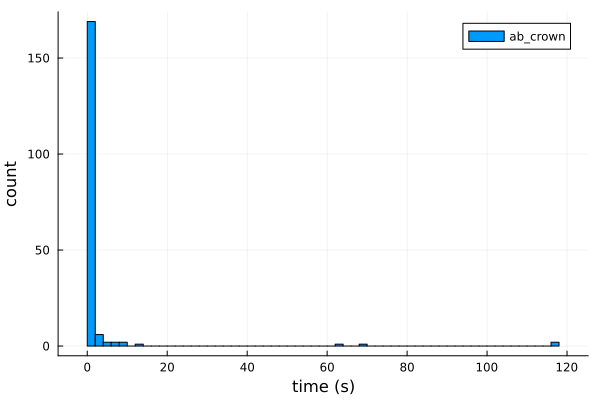

In [11]:
ab_df = DataFrame(CSV.File("./abcrown_result.csv", header=true))
ab_df[!,:value] = convert.(String15, ab_df[!,:value])
ab_df[ab_df.value .== "safe", :value] .= "holds"
ab_df[ab_df.value .== "unsafe", :value] .= "violated"
t = histogram(ab_df.time, bins=100, label="ab_crown")
xlabel!("time (s)")
ylabel!("count")
display(t)

In [52]:
println(sum(cr_df.value .== "holds"))
println(sum(cr_df.value .== "violated"))
println(sum(cr_df.value .== "unknown"))

55
35
96


In [56]:
ab_df = DataFrame(CSV.File("/home/verification/ModelVerification.jl/tmp/result.csv", header=true))
println(sum(ab_df.value .== "holds"))
println(sum(ab_df.value .== "violated"))
println(sum(ab_df.value .== "unknown"))

129
45
12


In [55]:
mv_df = DataFrame(CSV.File("/home/verification/ModelVerification.jl/tmp/crown_result.csv", header=true))
println(sum(mv_df.value .== "holds"))
println(sum(mv_df.value .== "violated"))
println(sum(mv_df.value .== "unknown"))

96
43
47


In [15]:
[mv_df[mv_df.value .!= ab_df.value, :value], ab_df[mv_df.value .!= ab_df.value, :value]]

2-element Vector{AbstractVector{String15}}:
 ["unknown", "unknown", "unknown", "unknown", "violated", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown", "unknown"]
 ["holds", "holds", "holds", "holds", "unknown", "holds", "holds", "holds", "holds", "holds", "violated", "holds"]